#           Fitting Effective Model parameters

## Initialization 

In [8]:
import numpy as np
from numpy.linalg import inv

In [9]:
%matplotlib inline
# %matplotlib notebook
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

In [10]:
import timeit
import time

In [20]:
import os

In [12]:
from scipy.optimize import lsq_linear
from scipy.optimize import minimize

In [13]:
import nlopt

In [14]:
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog

## Import required data

### Import GUI

In [15]:
#   Open the import file GUI
##  Remember to look at your list of Apps
infiles = filedialog.askopenfilename(multiple=True)
%gui tk

In [429]:
# The file that gets imported
infiles[0]

'/Users/willwiz/Downloads/Will-Rana-selected/specimen1/iso_wc/iso1data.txt'

In [430]:
## for indexing the polynomials based on the groups
index = np.genfromtxt(os.path.join(os.getcwd(), 'polysortedpositions.txt'), dtype=int) - 1

In [431]:
## indexes which changes between polynomial order and cross terms
key = np.genfromtxt(os.path.join(os.getcwd(), 'keypositions.txt'), dtype=int) - 1 + 1

In [432]:
cons_positions = np.genfromtxt(os.path.join(os.getcwd(), 'cospositions.txt'), dtype=int) - 1

In [433]:
importeddata = np.loadtxt(infiles[0])

In [434]:
importedconsdata = np.loadtxt(os.path.join(os.path.dirname(os.path.realpath(infiles[0])), 'consdata.txt'))

### Data processing

In [435]:
data_size = importeddata[:,1].size
print(data_size)

1113


In [436]:
# Import the deformation gradient tensor from the data
ftensor = np.zeros((data_size,2,2))
ftensor[:,0,0] = importeddata[:,0]
ftensor[:,0,1] = importeddata[:,1]
ftensor[:,1,0] = importeddata[:,2]
ftensor[:,1,1] = importeddata[:,3]
# Import the 2nd PK tensor from the data
Stensor = np.zeros((data_size,2,2))
Stensor[:,0,0] = importeddata[:,4]
Stensor[:,0,1] = importeddata[:,5]
Stensor[:,1,0] = importeddata[:,5]
Stensor[:,1,1] = importeddata[:,6]

In [437]:
# Compute the Cauchy stress the deformation gradient tensor from the data
Ttensor = np.zeros((data_size,2,2))
for i in range(data_size):
    Ttensor[i] = ftensor[i].dot(Stensor[i]).dot(ftensor[i].T)

In [438]:
## Low stress region points
ls_datapoints = np.array([ n for n,i in enumerate(Stensor) if i[0,0] < 50 and i[0,1] < 50 and i[1,1] < 50])

#### Compute the preferred direction

In [439]:
M = np.array([1,0])

In [440]:
S = np.array([-M[1], M[0]])

In [441]:
def calc_m(F,M):
    vec = F.dot(M)
    m = vec/np.sqrt(vec.dot(vec))
    return m

In [442]:
def cross_2D(M):
    return np.array([-M[1], M[0]])

In [443]:
m = np.zeros((data_size,2))
for i in range(data_size):
    m[i] = calc_m(ftensor[i], M)

In [444]:
s = np.zeros((data_size,2))
for i in range(data_size):
    s[i] = cross_2D(m[i])

#### Compute the kinematic variables

In [445]:
dat_lambdaM = np.zeros(data_size)
dat_lambdaS = np.zeros(data_size)
dat_phi = np.zeros(data_size)

In [446]:
## for lambda_M 
for i in range(data_size):
    dat_lambdaM[i] = m[i].dot(ftensor[i]).dot(M)
    
## for lambda_S
for i in range(data_size):
    dat_lambdaS[i] = s[i].dot(ftensor[i]).dot(S)

## for phi_M
for i in range(data_size):
    dat_phi[i] = m[i].dot(ftensor[i]).dot(S)/dat_lambdaM[i]

In [447]:
dat_gamma1 = np.log(dat_lambdaM)
dat_gamma2 = np.log(dat_lambdaS)
dat_gamma3 = dat_phi

In [448]:
gamma1 = dat_gamma1
gamma2 = dat_gamma2
gamma3 = dat_gamma3

#### Compute the response function variables

In [449]:
W1 = np.zeros(data_size)
W2 = np.zeros(data_size)
W3 = np.zeros(data_size)

In [450]:
for i in range(data_size):
    W1[i] = m[i].dot(Ttensor[i]).dot(m[i])

In [451]:
for i in range(data_size):
    W2[i] = s[i].dot(Ttensor[i]).dot(s[i])

In [452]:
for i in range(data_size):
    W3[i] = m[i].dot(Ttensor[i]).dot(s[i]) * dat_lambdaM[i] / dat_lambdaS[i]

## Define the model 

### Model Kinematics

In [453]:
poly_order = 10

In [454]:
def vectorize(top_degree, i, j, k):
    n = (top_degree//2 + 1)
    n2 = (top_degree + 1) * (n)
    return n2*i + n*j + k//2

In [455]:
def find_index(top_degree, y):
    n = (top_degree//2 + 1)
    n2 = (top_degree + 1) * (n)
    return y//n2, (y%n2)//n, 2*(y%n)

### Define the model form

In [681]:
def Psi(g1, g2, g3, c, y):
    i,j,k = find_index(poly_order, y)
    return c * (g1**i) * (g2**j) * (g3**k)

In [687]:
def strainenergy(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += Psi(g1, g2, g3, const[y], degrees[y])
    return result

### Define the response functions

In [458]:
def dW1(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0:
        return (i*g1**(i-1)) * (g2**j) * (g3**k)
    else:
        return 0

In [459]:
def dW2(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 0:
        return (g1**i) * (j*g2**(j-1)) * (g3**k)
    else:
        return 0

In [460]:
def dW3(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if k > 0:
        return (g1**i) * (g2**j) * (k*g3**(k-1))
    else:
        return 0

In [461]:
def dW11(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 1:
        return (i * (i-1) * g1**(i-2)) * (g2**j) * (g3**k)
    else:
        return 0

In [462]:
def dW22(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 1:
        return (g1**i) * (j * (j-1) * g2**(j-2)) * (g3**k)
    else:
        return 0

In [463]:
def dW33(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if k > 1:
        return (g1**i)*(g2**j)*(k*(k-1)*g3**(k-2))
    else:
        return 0

In [464]:
def dW12(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0 and j > 0:
        return (i*g1**(i-1))*(j*g2**(j-1))*(g3**k)
    else:
        return 0

In [465]:
def dW13(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if i > 0 and k > 0:
        return (i*g1**(i-1))*(g2**j)*(k*g3**(k-1))
    else:
        return 0

In [466]:
def dW23(g1, g2, g3, degrees):
    i,j,k = find_index(poly_order, degrees)
    if j > 0 and k > 0:
        return (g1**i)*(j*g2**(j-1))*(k*g3**(k-1))
    else:
        return 0

### Define the stiffness functions

In [467]:
def rW1(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(phi**2 /lm2/ls2 + .5 * phi**4 /ls2/ls2)*dW2(*x) \
            +(2*phi*dW3(*x) - 0.5*dW1(*x) + 0.25*dW11(*x) + phi**2 * dW33(*x) - phi*dW13(*x))/lm2/lm2 \
            +phi**2 /lm2/ls2 * (.5*dW12(*x) - phi*dW23(*x)) + 0.25 * phi**4 /ls2/ls2 * dW22(*x)

In [468]:
def rW2(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.5*(phi/lm2/ls2 + phi**3/ls2/ls2) * dW2(*x) \
            +0.5/lm2/lm2*(0.5*dW13(*x) - dW3(*x) - phi*dW33(*x)) \
            +0.25*phi/lm2/ls2*(3*phi*dW23(*x) - dW12(*x)) - 0.25 * phi**3 /ls2/ls2 * dW22(*x)

In [469]:
def rW3(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25 * phi**2/ls2/ls2 *(dW22(*x) - 2*dW2(*x)) + 0.25/lm2/ls2*(dW12(*x) - 2*phi*dW23(*x))

In [470]:
def rW4(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return -(0.25/lm2 + 0.5*phi**2/ls2)/ls2*dW2(*x) + 0.25 * phi**2 /ls2/ls2*dW22(*x) \
            +0.25/lm2/lm2*dW33(*x) - 0.5*phi/lm2/ls2 * dW23(*x)

In [471]:
def rW5(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    lm2 = np.exp(g1)**2
    ls2 = np.exp(g2)**2
    phi = g3
    return 0.25*phi/ls2/ls2*(2*dW2(*x) - dW22(*x)) + 0.25/lm2/ls2*dW23(*x)

In [472]:
def rW6(g1, g2, g3, degrees):
    x = g1, g2, g3, degrees
    ls2 = np.exp(g2)**2
    return 0.25/ls2/ls2*(dW22(*x) - 2*dW2(*x))

### Define the stress

In [473]:
def responseW1(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW1(g1,g2,g3,degrees[y])
    return result

In [474]:
def responseW2(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW2(g1,g2,g3,degrees[y])
    return result

In [475]:
def responseW3(g1, g2, g3, const, degrees):
    result = 0.0
    for y in range(const.size):
        result += const[y]*dW3(g1,g2,g3,degrees[y])
    return result

In [476]:
def cauchy_stress(lambda1, lambda3, const, degrees):
    result = 0.0
    gamma1 = np.log(lambda1)
    gamma2 = np.log(lambda3)
    gamma3 = 0.0
    W1 = responseW1(gamma1, gamma2, gamma3, const, degrees)
    return W1/lambda1/lambda1

## Precompute the problem

### Define the response matrix

In [477]:
def pre_W1(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW1(g1[x],g2[x],g3[x],y)
    return preArray

In [478]:
def pre_W2(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW2(g1[x],g2[x],g3[x],y)
    return preArray

In [479]:
def pre_W3(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = dW3(g1[x],g2[x],g3[x],y)
    return preArray

### Define the elasticity matrix

In [480]:
def pre_rW1(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW1(g1[x], g2[x], g3[x], y)
    return preArray

In [481]:
def pre_rW2(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW2(g1[x], g2[x], g3[x], y)
    return preArray

In [482]:
def pre_rW3(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW3(g1[x], g2[x], g3[x], y)
    return preArray

In [483]:
def pre_rW4(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW4(g1[x], g2[x], g3[x], y)
    return preArray

In [484]:
def pre_rW5(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW5(g1[x], g2[x], g3[x], y)
    return preArray

In [485]:
def pre_rW6(g1, g2, g3, degrees):
    npoly = degrees.max() + 1
    data_size = g1.size
    preArray = np.zeros((data_size, npoly))
    for x in range(data_size):
        for y in degrees:
            preArray[x,y] = rW6(g1[x], g2[x], g3[x], y)
    return preArray

### Precompute the response matrix

In [486]:
W1tensor = pre_W1(gamma1, gamma2, gamma3, index[:key.max()+1])
W2tensor = pre_W2(gamma1, gamma2, gamma3, index[:key.max()+1])
W3tensor = pre_W3(gamma1, gamma2, gamma3, index[:key.max()+1])

In [487]:
Wtensor = np.concatenate((W1tensor,W2tensor,W3tensor), axis = 0)
Wvector = np.concatenate((W1,W2,W3))

### Precompute the elasticity matrix

In [488]:
g1_cons_points = np.log(importedconsdata[:,0])
g2_cons_points = np.log(importedconsdata[:,3])
g3_cons_points = importedconsdata[:,1]/importedconsdata[:,0]

In [489]:
# cons_n_axis = 4

# def set_range(g):
#     global cons_degree
#     delta = (g.max() - g.min()) / cons_n_axis
#     return np.arange(g.min(), g.max() + delta/2, delta)

# def compute_cons_points(g1,g2,g3):
#     points = np.zeros(((cons_n_axis+1)**3,3))
#     z = 0 
#     for i in set_range(g1):
#         for j in set_range(g2):
#             for k in set_range(g3):
#                 cons_points[z] = np.array([i,j,k])
#                 z += 1

# #########################
# [g1_cons_points,g2_cons_points,g3_cons_points] = compute_cons_points(gamma1, gamma2, gamma3).T

In [490]:
rW_tensor_1 = pre_rW1(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_2 = pre_rW2(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_3 = pre_rW3(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_4 = pre_rW4(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_5 = pre_rW5(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])
rW_tensor_6 = pre_rW6(g1_cons_points, g2_cons_points, g3_cons_points, index[:key.max()+1])

In [602]:
ncons = g1_cons_points.size

## Fit the low stress region

### Data processing

In [491]:
ls_W1 = pre_W1(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
ls_W2 = pre_W2(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
ls_W3 = pre_W3(gamma1[ls_datapoints], gamma2[ls_datapoints], gamma3[ls_datapoints], index[[3,4,5,6]])
############################################################
ls_Wtensor = np.concatenate((ls_W1,ls_W2,ls_W3), axis = 0)
ls_Wvector = np.concatenate((W1[ls_datapoints],W2[ls_datapoints],W3[ls_datapoints]))

In [508]:
ls_A = np.zeros((3*ls_datapoints.size,3))

for i in range(3*ls_datapoints.size):
    ls_A[i,0] = ls_Wtensor[i,index[3]]
    ls_A[i,1] = ls_Wtensor[i,index[4]] + ls_Wtensor[i,index[5]]
    ls_A[i,2] = ls_Wtensor[i,index[6]]

### Functions

In [509]:
#################### Objective function ####################
def ls_obj(x):
    sse = ls_A.dot(x) - ls_Wvector
    return np.dot(sse,sse)

#################### Jacobian ####################
def ls_obj_jac(x):
    jac = np.zeros(3)
    for i in range(3):
        jac[i] = 2*((ls_A.dot(x) - ls_Wvector).dot(ls_A[:,i]))
    return jac

In [510]:
ls_cons = (
            {'type': 'ineq', 'fun': lambda x: x[1], 'jac' : lambda x: np.array([0,1,0])},
            {'type': 'ineq', 'fun': lambda x: x[2], 'jac' : lambda x: np.array([0,0,1])},
            {'type': 'ineq', 'fun': lambda x: x[1]*x[1]-x[0]*x[0], 'jac' : lambda x: np.array([-2*x[0],2*x[1],0])}
    )

### Parameter optimization

In [511]:
#################### Given an initial guess ####################
ig = np.array([200,200,50])

In [512]:
ls_obj(low_results.x)

1187439.9117098616

In [546]:
low_results=minimize(ls_obj, ig, jac=ls_obj_jac,
                     constraints=ls_cons, method='SLSQP',
                     options={'disp': True, 'ftol':1e-14,'maxiter' : 100000, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1     1     1.014403E+05     1.909716E+03
    2     4     5.716294E+04     5.530376E+02
    3     6     5.133847E+04     4.433666E+02
    4     8     4.800988E+04     3.170925E+02
    5     9     4.711066E+04     2.197677E+02
    6    10     4.659490E+04     1.619158E+01
    7    11     4.659450E+04     1.518290E+01
    8    12     4.659450E+04     1.513122E+01
    9    13     4.659450E+04     1.513167E+01
   10    18     4.659450E+04     1.513167E+01
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 46594.49844748647
            Iterations: 10
            Function evaluations: 29
            Gradient evaluations: 10


In [514]:
#################### Assign the final results
ls_terms = index[[3,4,5,6]]
ls_parms_val = np.array([low_results.x[0],low_results.x[1],low_results.x[1],low_results.x[2]])
print(ls_parms_val)

[ 250.33146815  250.33146815  250.33146815   61.02414898]


In [515]:
ls_parms_val = np.array([200,  200,   200,   50.        ])

### Plot the results

##### Plot for W1

In [516]:
ls_parms_val

array([ 200.,  200.,  200.,   50.])

In [517]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W1[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW1(X[i], Y[i], 0.0, ls_parms_val, ls_terms)


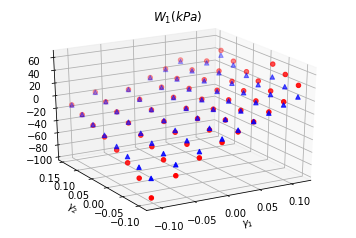

In [518]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_2$')
plt.savefig(infiles[0][:-4]+'ls_W1scatter.png',dpi=500,bbox_inches='tight')
plt.show()

##### Plot for W2

In [519]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W2[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW2(X[i], Y[i], 0.0, ls_parms_val, ls_terms)


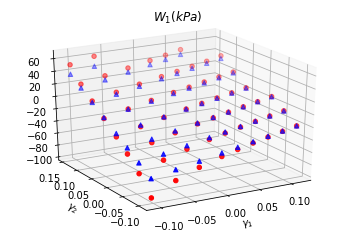

In [520]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_2$')
plt.savefig(infiles[0][:-4]+'ls_W2scatter.png',dpi=500,bbox_inches='tight')
plt.show()

##### Plot for W3

In [521]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in ls_datapoints:
    if abs(gamma2[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma3[i])
        Z.append(W3[i])
########################################
# Compute the fitted surface
Zfit = np.zeros(len(X))
for i in range(len(X)):
    Zfit[i] = responseW3(X[i], 0.0, Y[i], ls_parms_val, ls_terms)


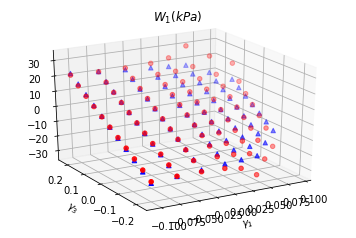

In [522]:
fig_ls_data = plt.figure()
ax = fig_ls_data.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
ax.scatter(X,Y,Zfit, c='b', marker='^')
ax.view_init(elev=25., azim=240)
ax.set_title(r'$W_1 (kPa)$')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_3$')
plt.savefig(infiles[0][:-4]+'ls_W3scatter.png',dpi=500,bbox_inches='tight')
plt.show()

### Post processing to remove the toe region

In [523]:
hs_vec_b = np.zeros(Wvector.size)
####
# Computes the Wvector data while removing the low stress component
for i in range(Wvector.size):
    hs_vec_b[i] = Wvector[i] - Wtensor[i,ls_terms].dot(ls_parms_val)

## Define the optimization problem

### Define the objective function

In [525]:
def obj_f(const, degrees):
#     sse = np.log(np.abs(Wtensor[:,degrees].dot(const) - Wvector) + 1)
    sse = Wtensor[:,degrees].dot(const) - hs_vec_b
    return np.dot(sse,sse)




def obj_f_jac(const, degrees):
    jac = np.zeros(degrees.size)
    for i in range(degrees.size):
        jac[i] = 2*((Wtensor[:,degrees].dot(const) - hs_vec_b).dot(Wtensor[:,degrees[i]]))
    return jac

### Define the constraint functions

In [608]:
def psi_1(i, degrees, x):
    return rW_tensor_1[i,degrees].dot(x)

def psi_2(i, degrees, x):
    return rW_tensor_2[i,degrees].dot(x)

def psi_3(i, degrees, x):
    return rW_tensor_3[i,degrees].dot(x)

def psi_4(i, degrees, x):
    return rW_tensor_4[i,degrees].dot(x)

def psi_5(i, degrees, x):
    return rW_tensor_5[i,degrees].dot(x)

def psi_6(i, degrees, x):
    return rW_tensor_6[i,degrees].dot(x)

In [609]:
def d_psi_1(i, degrees, j):
    return rW_tensor_1[i,degrees[j]]

def d_psi_2(i, degrees, j):
    return rW_tensor_2[i,degrees[j]]

def d_psi_3(i, degrees, j):
    return rW_tensor_3[i,degrees[j]]

def d_psi_4(i, degrees, j):
    return rW_tensor_4[i,degrees[j]]

def d_psi_5(i, degrees, j):
    return rW_tensor_5[i,degrees[j]]

def d_psi_6(i, degrees, j):
    return rW_tensor_6[i,degrees[j]]

In [1048]:
def constraint1(i, degrees, x):
    return psi_1(i, degrees, x)


def constraint2(i, degrees, x):
    return psi_6(i, degrees, x)


def constraint3(i, degrees, x):
    return psi_4(i, degrees, x)


def constraint4(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return (w1*w6 - w3*w3)


def constraint5(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    return (w1*w4 - w2*w2)


def constraint6(i, degrees, x):
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return (w6*w4 - w5*w5)


def constraint7(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    return  (w1*( w4*w6 - w5*w5 ) - w3*( w3*w4 - w5*w2 ) + w2*( w3*w5 - w6*w2 ))

In [1049]:
def cons1_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_1(i, degrees, j)
    return jacob


def cons2_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_6(i, degrees, j)
    return jacob


def cons3_jac(i, degrees, x):
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = d_psi_4(i, degrees, j)
    return jacob


def cons4_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = (w6*d_psi_1(i, degrees, j) + w1*d_psi_6(i, degrees, j) - 2* w3*d_psi_3(i, degrees, j))
    return jacob


def cons5_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = (w4*d_psi_1(i, degrees, j) + w1*d_psi_4(i, degrees, j) - 2*w2*d_psi_2(i, degrees, j))
    return jacob


def cons6_jac(i, degrees, x):
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = (w4*d_psi_6(i, degrees, j) + w6*d_psi_4(i, degrees, j) - 2* w5*d_psi_5(i, degrees, j))
    return jacob


def cons7_jac(i, degrees, x):
    w1 = psi_1(i, degrees, x)
    w2 = psi_2(i, degrees, x)
    w3 = psi_3(i, degrees, x)
    w4 = psi_4(i, degrees, x)
    w5 = psi_5(i, degrees, x)
    w6 = psi_6(i, degrees, x)
    n = degrees.size
    jacob = np.zeros(n)
    for j in range(n):
        jacob[j] = (( w4*w6 - w5*w5 )*d_psi_1(i, degrees, j) + w1*w4*d_psi_6(i, degrees, j) 
                    + w1*w6*d_psi_4(i, degrees, j) - 2*w1*w5*d_psi_5(i, degrees, j)
                    - 2*w3*w4*d_psi_3(i, degrees, j) + w5*w2*d_psi_3(i, degrees, j)
                    - w3*w3*d_psi_4(i, degrees, j) + w3*w2*d_psi_5(i, degrees, j) + w3*w5*d_psi_2(i, degrees, j)
                    + w3*w5*d_psi_2(i, degrees, j) - 2*w6*w2*d_psi_2(i, degrees, j)
                    + w2*w5*d_psi_3(i, degrees, j) + w2*w3*d_psi_5(i, degrees, j) - w2*w2*d_psi_6(i, degrees, j)
                   )
    return jacob




## Forward Selection: Model enhancement

In [530]:
lb = np.full(index.size, -np.inf)
ub = np.full(index.size, np.inf)

for i in cons_positions:
    lb[i] = 0
    
    

In [531]:
res_forward = [0 for i in range(key.size)]
cost_forward = [0 for i in range(key.size)]


for i in range(key.size):
    testlist = range(3,key[i])
    res_forward[i] = lsq_linear(Wtensor[:,index[testlist]], hs_vec_b, \
                          bounds=(lb[testlist], ub[testlist]), \
                          method='bvls', lsmr_tol='auto', max_iter=10000, verbose=2)
    cost_forward[i] = res_forward[i].cost

The unconstrained solution is optimal.
Final cost 6.1851e+07, first-order optimality 1.94e-11
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         5.1080e+07                                    3.96e+01    
       1         5.1077e+07      3.09e+03       2.10e+04       7.57e-11    
The first-order optimality measure is less than `tol`.
Number of iterations 2, initial cost 5.1080e+07, final cost 5.1077e+07, first-order optimality 7.57e-11.
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         3.8047e+07                                    6.80e+03    
       1         3.0259e+07      7.79e+06       4.49e+05       2.23e+02    
       2         3.0256e+07      2.85e+03       1.14e+04       4.79e-10    
       3         3.0256e+07      0.00e+00       0.00e+00       4.79e-10    
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 3.8047e+07, final cost 3.0256e+07, first

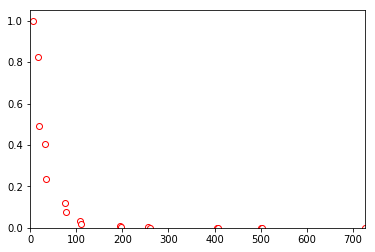

In [532]:
plt.plot(key, cost_forward/cost_forward[0],'ro',markerfacecolor='white')
plt.axis([0, key.max(), 0, 1.05])
plt.savefig('forwardselectionresult.png',dpi=500,bbox_inches='tight')
plt.show()

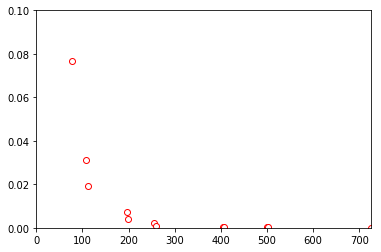

In [533]:
plt.plot(key, cost_forward/cost_forward[0],'ro',markerfacecolor='white')
plt.axis([0, key.max(), 0, 0.1])
plt.savefig('forwardselectionzoomed.png',dpi=500,bbox_inches='tight')
plt.show()

In [534]:
key

array([  7,  18,  20,  32,  35,  75,  77, 108, 111, 196, 198, 256, 259,
       405, 407, 500, 503, 726])

In [535]:
nk = 10
key[nk]

198

## Model parameter covariance

### Compute the covariance matrix 

In [826]:
CovM = (Wtensor.T).dot(Wtensor)
CovM[0,0] = 1.0

trace = np.diag(np.divide(1.0, np.sqrt(CovM.diagonal())))

corM = trace.dot(CovM).dot(trace)

### Parameter fitness

In [1069]:
max_parm_cor = 0.55

In [1070]:
def parm_bestfit(i):
    return (Wvector.dot(Wtensor[:,i]))/(Wtensor[:,i].dot(Wtensor[:,i]))

########################################


# def parm_fitness(i):
#     bval = parm_bestfit(i)
#     eps = bval*Wtensor[:,i] - Wvector
#     return (eps.dot(eps))/(Wvector.dot(Wvector))

########################################

def parm_fitness(i):
    bval = parm_bestfit(i)
    eps = bval*Wtensor[:,i] - hs_vec_b
    return (eps.dot(eps))/(hs_vec_b.dot(hs_vec_b))

In [1071]:
bestset = np.zeros(key.max())
for i in np.arange(7,key.max()):
    testvec = np.array(np.where(np.abs(corM[index[i],index]) > max_parm_cor)[0])
    testval = np.array([parm_fitness(i) for i in testvec])
    bestset[i] = testvec[ testval == testval.min()]

    
setunion = np.union1d(bestset,bestset[7:10])
setunion = setunion.astype(int)
setunion = np.setdiff1d(setunion, [0,1,2,3,4,5,6])
print(setunion.size)

24


In [1075]:
for i in setunion:
    print(find_index(10, index[i]))

(2, 0, 2)
(3, 0, 0)
(0, 3, 0)
(2, 3, 0)
(0, 3, 2)
(2, 3, 2)
(3, 3, 2)
(4, 0, 0)
(1, 4, 0)
(1, 0, 4)
(2, 0, 4)
(1, 1, 4)
(3, 4, 0)
(3, 0, 4)
(2, 1, 4)
(4, 4, 0)
(4, 2, 2)
(1, 3, 4)
(4, 1, 4)
(6, 1, 2)
(7, 1, 0)
(7, 0, 4)
(8, 0, 2)
(6, 7, 8)


In [1076]:
model_exp = setunion

## Backwards Elimination: Model refinement

In [1077]:
def obj_f(const, degrees):
#     sse = np.log(np.abs(Wtensor[:,degrees].dot(const) - Wvector) + 1)
    sse = Wtensor[:,degrees].dot(const) - hs_vec_b
    return np.dot(sse,sse)




def obj_f_jac(const, degrees):
    jac = np.zeros(degrees.size)
    for i in range(degrees.size):
        jac[i] = 2*((Wtensor[:,degrees].dot(const) - hs_vec_b).dot(Wtensor[:,degrees[i]]))
    return jac

In [1078]:
def f(x, grad):
    if grad.size > 0:
        global model_exp
        grad[:] = obj_f_jac(x, index[model_exp])
        return obj_f(x, index[model_exp])

    
def c(result, x, grad):
    if grad.size > 0:
        global model_exp
        for i in range(ncons):
            result[3*i] = -constraint1(i, index[model_exp], x)
            result[3*i + 1] = -constraint4(i, index[model_exp], x)
            result[3*i + 2] = -constraint7(i, index[model_exp], x)
            grad[3*i,:] = -cons1_jac(i, index[model_exp], x)
            grad[3*i + 1,:] = -cons4_jac(i, index[model_exp], x)
            grad[3*i + 2,:] = -cons7_jac(i, index[model_exp], x)
    return 0
                 
            

In [1156]:
del opt

In [1157]:
lb = np.full(index.size, -10.0e-10)
ub = np.full(index.size, -10.0e-10)

for i in cons_positions:
    lb[i] = 0

In [1158]:
opt = nlopt.opt(nlopt.LD_MMA, model_exp.size)
# opt = nlopt.opt(nlopt.GN_ISRES, model_exp.size)
opt.set_min_objective(f)

opt.set_lower_bounds(lb[index[model_exp]])
opt.set_upper_bounds(ub[index[model_exp]])

opt.set_ftol_rel(1.0e-6)
opt.set_ftol_abs(0)
opt.set_xtol_rel(0)
opt.set_xtol_abs(0)

opt.set_maxeval(100)
opt.set_maxtime(900)

# opt.add_inequality_mconstraint(c, np.full(3*ncons, 1.0e-14))
# opt.remove_inequality_mconstraint()

In [1159]:
# ig = np.zeros(model_exp.size)
temp_sol = inv((Wtensor[:,index[model_exp]].T).dot(Wtensor[:,index[model_exp]])).dot(Wtensor[:,index[model_exp]].T).dot(hs_vec_b)
# ig = np.sqrt(temp_sol.clip(min=0, max = 1000))
ig = temp_sol.clip(min=0)
# ig = np.zeros(model_exp.size)

In [1160]:
testgrad = np.zeros(model_exp.size)

In [1163]:
xopt = opt.optimize(ig)

ValueError: nlopt invalid argument

In [1133]:
print(xopt)
print(opt.last_optimize_result())
print(opt.last_optimum_value())

[  7.91392027e+03   4.17906958e+03   3.27872515e+03   3.84676221e+04
   1.01877503e+04   3.42494254e+06   1.02468203e+08   1.38919290e+04
  -6.98021047e+04  -2.06720362e+04   4.09144970e+05  -6.19456514e+04
   1.39481524e+06   8.59242975e+05   4.21965471e+06   3.52828784e+07
   7.18181268e+07  -1.89925818e+05  -1.32978370e+05   5.94249977e+08
   7.62955477e+05   6.43961698e+09   2.72233037e+09   2.37984605e+16]
5
137611796.03163126


In [1100]:
f(ig, testgrad)

72403923.353728548

In [1101]:
f(xopt, testgrad)

42201396.267439261

In [1102]:
f(temp_sol, testgrad)

42199214.127890594

In [1164]:
constrainted_results=minimize(f, ig, args=(testgrad,), method='SLSQP',options={'disp': True, 'maxiter' : 100000, 'iprint': 2})

  NIT    FC           OBJFUN            GNORM
    1    26     7.240392E+07     4.702658E+03
    2    53     7.102262E+07     1.233604E+03
    3    79     6.955601E+07     1.181316E+03
    4   105     6.217979E+07     1.261684E+03
    5   131     5.330542E+07     7.676681E+02
    6   157     5.309674E+07     2.130464E+02
    7   183     5.305333E+07     2.076511E+02
    8   209     5.281289E+07     1.952524E+02
    9   235     5.189257E+07     1.384765E+02
   10   261     5.108483E+07     1.279414E+02
   11   287     5.106864E+07     1.266027E+02
   12   313     5.098427E+07     1.288342E+02
   13   339     5.054201E+07     1.199396E+02
   14   365     4.905119E+07     8.622210E+01
   15   391     4.841541E+07     9.831963E+01
   16   417     4.840438E+07     9.825350E+01
   17   443     4.833940E+07     1.040793E+02
   18   469     4.814885E+07     1.238305E+02
   19   495     4.777961E+07     1.591336E+02
   20   521     4.724035E+07     1.686179E+02
   21   547     4.663709E+07     1

In [1165]:
# finalparameters = parmresults[rterms]
# finalparameters = ig
# finalparameters = xopt
finalparameters = constrainted_results.x

In [1166]:
finalexponenets = index[model_exp]

## Examining the results

### Final parameters

### Quality of fit

In [1167]:
def set_range(g, n):
    delta = (g.max() - g.min()) / n
    return np.arange(g.min(), g.max() + delta/2, delta)

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


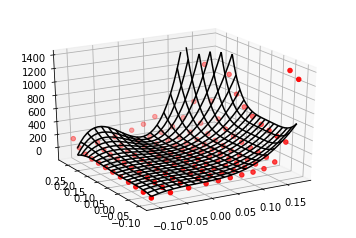

In [1168]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W1[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW1(Xsurf[i][j], Ysurf[i][j], 0.0, 
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW1surf.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


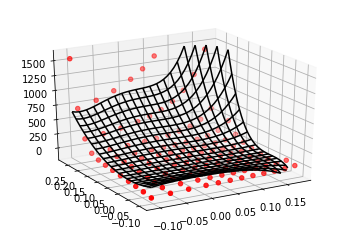

In [1169]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma3[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma2[i])
        Z.append(W2[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW2(Xsurf[i][j], Ysurf[i][j], 0.0, 
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW2surf.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in less


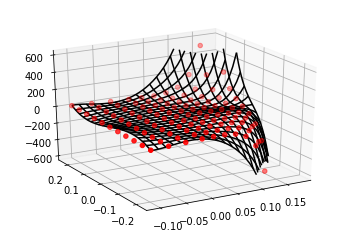

In [1170]:
########################################
# Select the data for plotting
X = []
Y = []
Z = []
for i in range(gamma1.size):
    if abs(gamma2[i]) < np.finfo(float).eps:
        X.append(gamma1[i])
        Y.append(gamma3[i])
        Z.append(W3[i])
        
        
########################################
# Compute the fitted surface
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zsurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zsurf[i][j] = responseW3(Xsurf[i][j], 0.0, Ysurf[i][j],
                                 finalparameters, finalexponenets)
        
########################################
# Truncate the surface 
Zsurf[Zsurf>max(Z)] = np.NaN
Zsurf[Zsurf<min(Z)] = np.NaN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X,Y,Z, c='r', marker='o')
surf = ax.plot_wireframe(Xsurf, Ysurf, Zsurf, rstride=2, cstride=2, color='black')
ax.view_init(elev=25., azim=240)
plt.savefig(infiles[0][:-4]+'fitW3surf.png',dpi=500,bbox_inches='tight')
plt.show()

In [1171]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma3[i]) < np.finfo(float).eps:
#         X.append(gamma1[i])
#         Y.append(gamma2[i])
#         Z.append(W1[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW1(X[i], Y[i], 0.0, finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W1scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


In [1172]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma3[i]) < np.finfo(float).eps:
#         X.append(gamma1[i])
#         Y.append(gamma2[i])
#         Z.append(W2[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW2(X[i], Y[i], 0.0, finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W2scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


In [1173]:
# ########################################
# # Select the data for plotting
# X = []
# Y = []
# Z = []
# for i in range(gamma1.size):
#     if abs(gamma1[i]) < np.finfo(float).eps:
#         X.append(gamma2[i])
#         Y.append(gamma3[i])
#         Z.append(W3[i])
# ########################################
# # Compute the fitted surface
# Zfit = np.zeros(len(X))
# for i in range(len(X)):
#     Zfit[i] = responseW3(0.0, X[i], Y[i], finalparameters, finalexponenets)

    
# ########################################
# # Plot the results
# fig_ls_data = plt.figure()
# ax = fig_ls_data.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z, c='r', marker='o')
# ax.scatter(X,Y,Zfit, c='b', marker='^')
# ax.view_init(elev=25., azim=240)
# ax.set_title(r'$W_1 (kPa)$')
# ax.set_xlabel(r'$\gamma_1$')
# ax.set_ylabel(r'$\gamma_2$')
# plt.savefig(infiles[0][:-4]+'W3scatter.png',dpi=500,bbox_inches='tight')
# plt.show()


### Convexity

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


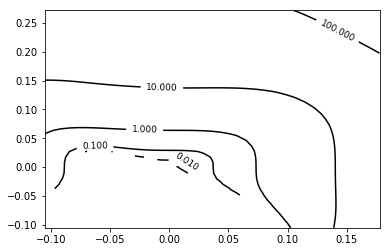

In [1174]:
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma2, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(Xsurf[i][j], Ysurf[i][j], 0.0,
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


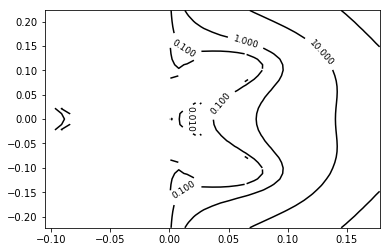

In [1175]:
Xsurf = set_range(gamma1, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(Xsurf[i][j], 0.0, Ysurf[i][j],
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

/Users/willwiz/anaconda/lib/python3.5/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


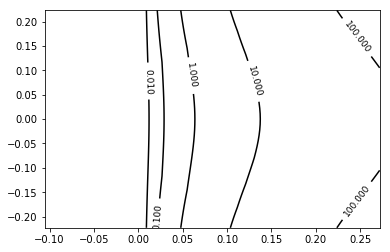

In [1176]:
Xsurf = set_range(gamma2, 40)
Ysurf = set_range(gamma3, 40)
Xsurf, Ysurf = np.meshgrid(Xsurf, Ysurf)
Zenergysurf = np.zeros(Xsurf.shape)
for i in range(Xsurf.shape[0]):
    for j in range(Xsurf.shape[1]):
        Zenergysurf[i][j] = strainenergy(0.0, Xsurf[i][j], Ysurf[i][j], 
                                         finalparameters, finalexponenets)   
        
        
plt.figure()
CS = plt.contour(Xsurf, Ysurf, Zenergysurf, 20,
                 colors='k',locator=plt.LogLocator()# negative contours will be dashed by default
                 )
fmt = ticker.LogFormatterMathtext()
fmt.create_dummy_axis()
plt.clabel(CS, CS.levels, fontsize=9, inline=1)
plt.savefig(infiles[0][:-4]+'fitenergylogcontourlog12.png',dpi=500,bbox_inches='tight')
plt.show()

### Advanced results

In [1177]:
for i in range(ncons):
    print(constraint1(i, finalexponenets, finalparameters))

6938.1859332
13737.5941439
967.481214545
842.981342399
2402.39284766
4093.88999877
857.179409702
537.150167746
573.500783841
1797.31431964
6863.52450074
967.481214545
842.981342399
2402.39284766
4093.88999877
-687.830293015
205.097913595
6938.1859332
13737.5941439
-25.2126725083
-109.288979885
-237.976356328
-194.4366775
-94.425967196
-136.358008923
-178.282209522
-380.656889021
62.1982633784
0.0
-53.4858692998
-377.648260181
-94.425967196
-136.358008923
-178.282209522
-380.656889021
-25.2126725083
-109.288979885
-237.976356328
-194.4366775
235.152130991
187.797212063
588.231033473
248.262251493
204.938425721
340.245184439
1093.86187196
327.442118199
234.181653099
238.713004292
515.559926235
248.262251493
204.938425721
340.245184439
1093.86187196
235.152130991
187.797212063
588.231033473
2124.2183029
3173.77329461
903.222867072
1086.72901672
1670.73377769
686.317565787
540.101065
627.350744108
1730.79414417
903.222867072
1086.72901672
1670.73377769
2124.2183029
3173.77329461
971.218240

In [1178]:
for i in range(ncons):
    print(constraint4(i, finalexponenets, finalparameters))

3070303.99345
9810822.61034
-1637734.99423
9080.1482718
720842.675616
1447610.25501
-781214.875619
21.7857228339
140242.020891
577821.908752
1886950.88617
-1637734.99423
9080.1482718
720842.675616
1447610.25501
-6632212.67494
-470994.530273
3070303.99345
9810822.61034
52889.8333414
-59388.3902647
-190597.988869
-167464.716443
118555.058122
-231.985899471
-78138.4881452
-200116.623783
-64072.6823317
0.0
-18655.7572168
-162340.570042
118555.058122
-231.985899471
-78138.4881452
-200116.623783
52889.8333414
-59388.3902647
-190597.988869
-167464.716443
-533456.092622
-43570.5066016
249251.826074
-301582.852274
251.662171834
151096.146907
571782.612152
-306821.494973
-0.304000331621
81509.1899747
230219.963023
-301582.852274
251.662171834
151096.146907
571782.612152
-533456.092622
-43570.5066016
249251.826074
-5353258.46917
80600.6497216
-589988.278732
33976.5231185
940784.093252
-290516.620849
-80.7161489537
264522.562176
622954.599774
-589988.278732
33976.5231185
940784.093252
-5353258.469

In [1179]:
for i in range(ncons):
    print(constraint7(i, finalexponenets, finalparameters))

93225046.2341
-7481416778.53
-141627279.479
-7658938.43162
-92003008.5718
-147549654.593
230609780.93
-5589.80513377
-19075827.5028
75816629.9512
1079333031.17
-141627279.479
-7658938.43162
-92003008.5718
-147549654.593
-6181872814.54
-386055912.637
93225046.2341
-7481416778.53
74352576.9261
-0.0
-276615613.732
-726011055.997
-8800494.77043
-0.0
-1190238.20308
2769360.08093
6351265.32093
0.0
-495830.413835
-44801171.4388
-8800494.77043
0.0
-1190238.20308
2769360.08093
74352576.9261
0.0
-276615613.732
-726011055.997
-65449083.3082
15818941.1783
-143269045.883
49425774.5636
-388236.039595
19878337.3243
92083427.8772
43283759.2896
15.8247072537
-1028502.51003
63104689.6169
49425774.5636
-388236.039595
19878337.3243
92083427.8772
-65449083.3082
15818941.1783
-143269045.883
-4704883543.34
-569471892.352
-136704713.018
-7159844.41745
142207643.495
72284714.453
9253.05159921
19955987.596
498155838.894
-136704713.018
-7159844.41745
142207643.495
-4704883543.34
-569471892.352
-60997765.104


## Auxilary code

In [1180]:
initiallist = setunion
removedlist = []
costlist = np.full(sortedpositions.size, np.inf)
costresults = []
parmresults = []
termresults = []
initialguess = np.zeros(keypositions[nk])
timecost = np.zeros((len(initiallist) - 4))
res = [[0 for j in range(max(initiallist)+1)] for i in range(len(initiallist))]

NameError: name 'sortedpositions' is not defined

In [ ]:
for i in range(len(initiallist) -4):
    start = time.time()
    for j in initiallist[4:]:
        testlist = [k for k in initiallist if k!=j]
        res[i][j] = lsq_linear(Wtensor[:,sortedpositions[testlist]], Wvector, lsmr_tol='auto', max_iter=10000, verbose=0)
        costlist[j] = res[i][j].cost
    besti = costlist.argmin()
    initiallist.remove(besti)
    removedlist.append(besti)
    costresults.append(costlist[besti])
    parmresults.append(res[i][besti].x)
    termresults.append(np.array(initiallist))
    costlist[besti] = np.inf
    end = time.time()
    timecost[i] = end - start
    print(i)